# Результаты A/B теста
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


Будем анализировать А/Б тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользоваль совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Замечание: не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('data/ab_browser_test.csv',sep=',')


data['click_per_queries'] = data['n_clicks']/data['n_queries']
data['empty_query_share'] = data['n_nonclk_queries']/data['n_queries']

print(data.shape)
data.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


In [ ]:
data['browsers_per_user'] = data.groupby('userID')['browser'].transform('count')
data[data['browsers_per_user'] > 1]

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share,browsers_per_user
1478,1543,Browser #2,control,1,3,2,0.333333,0.666667,2
1479,1543,Browser #22,control,4,2,0,2.000000,0.000000,2
1706,1783,Browser #2,exp,6,3,1,2.000000,0.333333,2
1707,1783,Browser #20,exp,66,42,15,1.571429,0.357143,2
3352,3549,Browser #2,exp,14,18,10,0.777778,0.555556,2
...,...,...,...,...,...,...,...,...,...
521110,556320,Browser #22,exp,1,1,0,1.000000,0.000000,2
543986,579975,Browser #2,exp,0,1,1,0.000000,1.000000,2
543987,579975,Browser #22,exp,0,2,2,0.000000,1.000000,2
555654,592110,Browser #2,control,2,8,7,0.250000,0.875000,2


In [ ]:
df = data.groupby(['userID', 'slot']).agg({'n_clicks': 'sum', 'n_queries': 'sum'}).reset_index()
df['click_per_queries'] = df['n_clicks'] / df['n_queries']

df.nunique(), df.shape

(userID               565842
 slot                      2
 n_clicks                382
 n_queries               318
 click_per_queries      7438
 dtype: int64,
 (565842, 5))

Будем работать с числом кликов на количество пользовательских сессий. 

> Вообще, это ratio-метрика и к ней нужен особый подход. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [ ]:
# ваш код

100 * (df.groupby('slot')['n_clicks'].sum()['exp']/df.groupby('slot')['n_clicks'].sum()['control'] - 1)

1.6135689824415822

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ А/Б-теста

Внимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Для этого построим для контрольной и тестовой групп визуализации.

<Axes: ylabel='click_per_queries'>

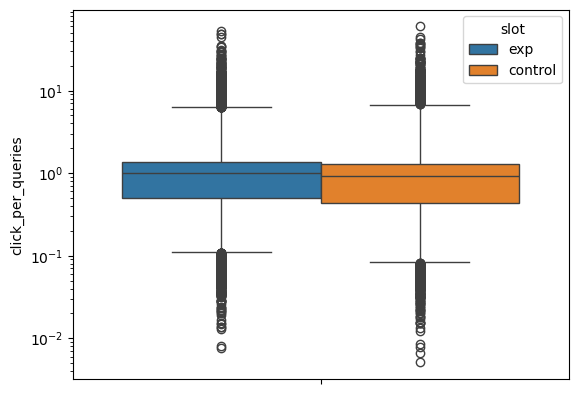

In [124]:
sns.boxplot(data=df, y='click_per_queries', hue='slot', orient='v', log_scale=True)

In [125]:
exp = df[df['slot']=='exp']['click_per_queries']
control = df[df['slot']=='control']['click_per_queries']

q1_exp, q2_exp = np.quantile(exp,[0.25, 0.75])
IQR_exp= abs(q2_exp - q1_exp)
left_exp, right_exp = q1_exp - 1.0 * IQR_exp, q2_exp + 1.0 * IQR_exp

exp_clear =  exp.loc[(exp >= left_exp) & (exp <= right_exp)]
exp_outlier = exp.loc[(exp < left_exp) | (exp > right_exp)]

q1_control, q2_control = np.quantile(control,[0.25, 0.75])
IQR_control = abs(q2_control - q1_control)
left_control, right_control = q1_control - 1.0 * IQR_control, q2_control + 1.0 * IQR_control

control_clear =  control.loc[(control >= left_control) & (control <= right_control)]
control_outlier = control.loc[(control < left_control) | (control > right_control)]

control_outlier.shape[0], exp_outlier.shape[0]

(21463, 22067)

<Axes: title={'center': 'Control group'}, xlabel='click_per_queries', ylabel='Count'>

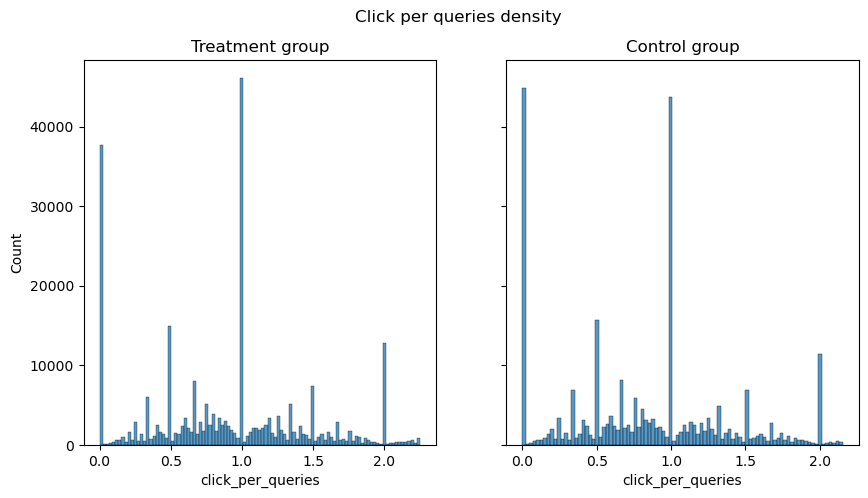

In [126]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10,5))
fig.suptitle('Click per queries density')

axes[0].set_title('Treatment group')
sns.histplot(exp_clear,ax=axes[0])

axes[1].set_title('Control group')
sns.histplot(control_clear, ax=axes[1])

In [127]:
df_clear = df.iloc[exp_clear.index.to_list()+control_clear.index.to_list()]

<Axes: ylabel='click_per_queries'>

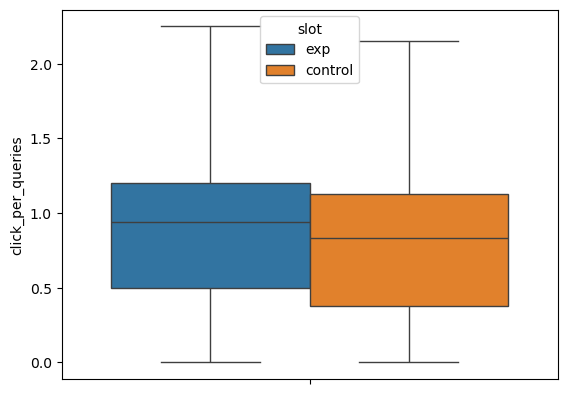

In [128]:
sns.boxplot(data=df_clear, y='click_per_queries', hue='slot', orient='v')

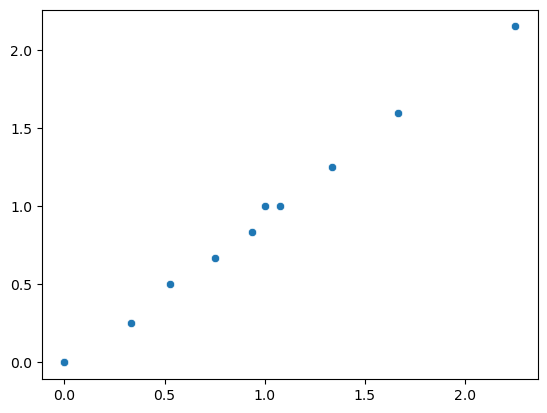

In [131]:
exp_quantiles = []
control_quantiles = []

quantiles = np.linspace(0, 1, 11)

for q in quantiles:
    exp_quantiles.append(np.quantile(exp_clear, q))
    control_quantiles.append(np.quantile(control_clear, q))

sns.scatterplot(x=exp_quantiles, y=control_quantiles)
plt.show()

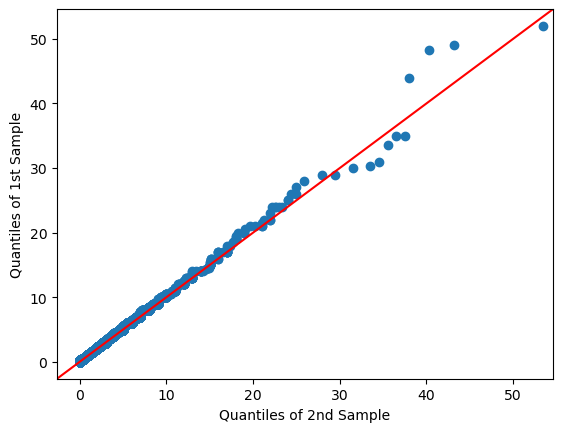

In [133]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import matplotlib.pyplot as plt

pp_exp = sm.ProbPlot(exp)
pp_control = sm.ProbPlot(control)

sm.qqplot_2samples(pp_exp, pp_control, line='45')
plt.show()

In [134]:
round(100 * control_outlier.shape[0]/control.shape[0], 2), round(100 * exp_outlier.shape[0]/exp.shape[0], 2)

(7.55, 7.84)

### Наблюдения:

- Похоже на то, что данные пришли из одного распределения и в группах отличия только в сдвиге (идеально для теста Манна-Уитни?)
- В каждой группе есть выбросы (по 7.55 и 7.84% в контролной и тестовой соответственно), тогда $z$-тест нам не подходит? Однако, мы не можем наверняка знать, насколько серьезное влияние эти выбросы оказали на ЦПТ и сломали ли они ее.
- старый-добрый ~~synn-vynn~~ bootstrap?

Если посчитать по выброкам средние и медианы, они окажутся очень похожими:

In [135]:
control.median(), control.mean(), exp.median(), exp.mean(), 

(0.9230769230769231, 1.0059805581337076, 1.0, 1.0814760334704223)

Попробуем применить бутстрап, чтобы понять, как распределена z-статистика и сравнить ее распределение с нормальным (ограничимся в рамках нее контрольной группой)

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не нужно делать бутстрап в бутстрапе (наш случай - __параметрический бутстрап__).

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитаем значения $z$-статистик,
4. Для получившегося вектора из $z$-статистик построим `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

In [153]:
np.random.seed(42)

n_boot_samples = 10**4
n = control.size
theta = control.mean()

theta_hat = []
sigma_hat = []
z = []
for _ in range(n_boot_samples):
    bootstrap_sample = np.random.choice(control, size=n, replace=True)
    theta_hat.append(np.mean(bootstrap_sample))
    se_bootstrap = np.std(bootstrap_sample, ddof=1) / np.sqrt(n)
    z.append((np.mean(bootstrap_sample) - theta) / se_bootstrap)

In [154]:
np.array(z)

array([-0.24249327, -1.63932401,  1.53494995, ...,  1.30188837,
       -1.14996682, -0.09537338])

<Axes: ylabel='Count'>

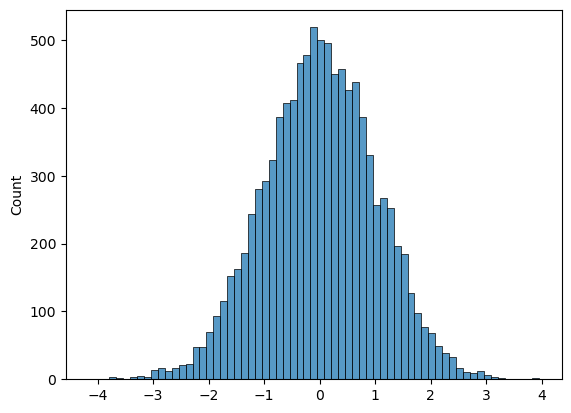

In [155]:
sns.histplot(z)

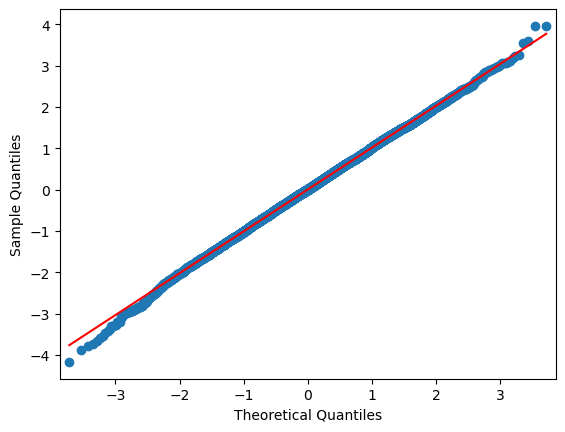

In [159]:
sm.qqplot(np.array(z), sts.norm, line='s')

plt.show()

Xвосты распределения немного отличаются от стандартного нормального. Пока сделаем вид, что все хорошо и отличия на хвостах нет. Проверим гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

In [163]:
alpha = 0.01
x_hat_control = np.mean(control)
x_hat_exp = np.mean(exp)
diff = x_hat_exp - x_hat_control
var_hat_control = np.var(control, ddof=1)/control.size
var_hat_exp = np.var(exp, ddof=1)/exp.size


z_obs = diff/np.sqrt(var_hat_control + var_hat_exp)

p_val = 2 * (1 - sts.norm.cdf(abs(z_obs)))
p_val

0.0

Попробуем понять, какими при таких объемах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... Выберем какое-то адекватное значение MDE и получим, отталкиваясь от него, ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [181]:
var_control = np.var(control, ddof=1)
var_exp = np.var(exp, ddof=1)

n_control = control.size
n_exp = exp.size

se_diff = np.sqrt(var_control/n_control + var_exp/n_exp)
z_critical = sts.norm.ppf(1 - alpha/2)

se_diff, z_critical

mde = 0.001
z_power = (mde / se_diff) - z_critical
beta_z_test = sts.norm.cdf(z_power)
beta_z_test

0.013539767168524518

Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ. 

Проверим гипотезу с помощью бутстрапа!

1. Посчитаем наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создадим две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы. 
3. Сбутстрапируем выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитаем значение z-статистики. Повторим процедуру $B$ раз.
4. Для оценки `p-value` воспользуемся формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [184]:
h_ = df['click_per_queries'].mean()

control_recentered = control - x_hat_control + h_
exp_recentered = exp - x_hat_exp + h_


b = 10**4

n_control = control.size
n_exp = exp.size

control_means = []
exp_means = []

diff_bootstrap = []

for _ in range(b):
    sample_control = np.random.choice(control_recentered, size=n_control, replace=True)
    sample_exp = np.random.choice(exp_recentered, size=n_exp, replace=True)

    diff_bootstrap.append(np.mean(sample_exp) - np.mean(sample_control))

observed_diff = np.mean(exp) - np.mean(control)

p_value_bootstrap = 2 * np.mean(np.abs(diff_bootstrap) >= np.abs(observed_diff))

p_value_bootstrap

0.0

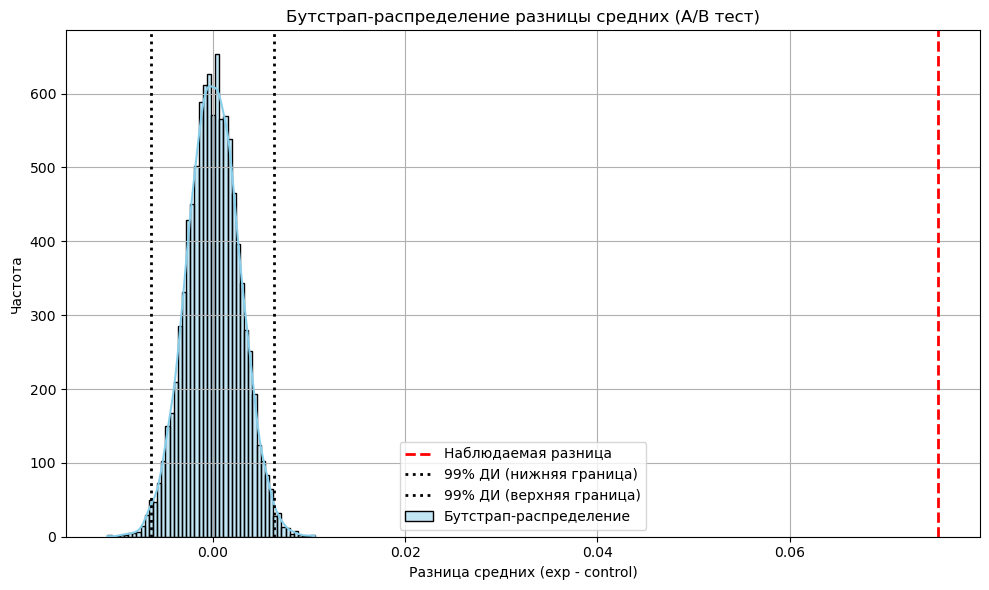

In [115]:
plt.figure(figsize=(10, 6))
sns.histplot(diff_bootstrap, bins=50, kde=True, color='skyblue', label='Бутстрап-распределение')
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, label='Наблюдаемая разница')
plt.axvline(np.percentile(diff_bootstrap, 1), color='black', linestyle=':', linewidth=2, label='99% ДИ (нижняя граница)')
plt.axvline(np.percentile(diff_bootstrap, 99), color='black', linestyle=':', linewidth=2, label='99% ДИ (верхняя граница)')
plt.title('Бутстрап-распределение разницы средних (A/B тест)')
plt.xlabel('Разница средних (exp - control)')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [ ]:
# ваш код

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [ ]:
# ваш код 

При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами: 

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

In [ ]:
# ваш код

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/) 

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись. 

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [ ]:
# ваш код 

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED. 

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [ ]:
# ваш код

__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

In [ ]:
# ваш код

__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку? 

In [ ]:
# ваш код

__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.

In [ ]:
# ваш код